# Mar 28, 2024: Total evidence of model classes

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
import copy

from scipy import sparse, stats
from scipy.special import gammaln
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni
from itertools import combinations, permutations, product


import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle


plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240603-11:56:14,804 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 25 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/density-{args.denst}'
FC_path = f'{ROI_RESULTS_path}/corr_mats'
SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')

0

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

In [5]:
def collect_sbm_fits(args, files):
    def get(name):
        l = [s for s in ssr if name in s]
        return l[0].split('-')[-1] if len(l) > 0 else '0'
    
    fits_df = []
    for file in tqdm(files):
        sbm = '_'.join(file.split('/')[-1].split('.')[0].split('_')[:-1])
        ssr = file.split('/')[-2].split('_')
        sub, ses, run = list(map(get, ['sub', 'ses', 'run']))
        
        # print(file)
        try:
            if 'dc-o' in sbm: continue 
            
            with open(f'{file}', 'rb') as f:
                all_vars = pickle.load(f)
                if len(all_vars) == 7:
                    [g, L, pmode, modes, marginals, state, Bes] = all_vars
                    converged = False
                elif len(all_vars) == 8:
                    [g, L, pmode, modes, marginals, state, Bes, converged] = all_vars
            
            # print(ssr, len(all_vars))
            
            df = pd.DataFrame({
                'sub':[int(sub[-2:])],
                'ses':[int(ses)],
                'run':[int(run)],
                'sbm':[sbm],
                'evidence':[L],
                'converged':[converged],
            })
            fits_df.append(df)
        except:
            pass
        
    fits_df = pd.concat(fits_df)
    fits_df = fits_df.sort_values(
        by=['sub', 'ses', 'run']
    ).reset_index(drop=True)

    return fits_df

In [6]:
from pathlib import Path
if Path(f'{NPY_path}/fits_df.pkl').is_file():
    fits_df = pd.read_pickle(f'{NPY_path}/fits_df.pkl')
    display(fits_df.head(n=5))
else:
    files = sorted(glob.glob(f'{SBM_path}/*/*', recursive=True))
    fits_df = collect_sbm_fits(args, files)
    fits_df = pd.pivot(
        data=fits_df, 
        columns=['sbm'],
        index=['sub', 'ses', 'run'],
        values=['evidence', 'converged'],
    )
    fits_df.to_pickle(f'{NPY_path}/fits_df.pkl')
    fits_df.head(n=1)

evidence                                                      \
sbm               sbm--a     sbm-dc-d     sbm-dc-h     sbm-nd-d     sbm-nd-h   
sub ses run                                                                    
1   1   0   -7192.538442 -6739.330287          NaN  -6577.57004 -6534.465287   
    2   0   -7064.143682 -6655.234076 -6636.347749 -6593.140076  -6542.03061   
    3   0   -7054.718139 -6651.722328  -6609.35665 -6546.892943  -6494.19689   
2   1   0   -6843.045927 -6408.384486 -6368.142153 -6337.029448 -6229.741573   
    2   0   -7085.601074 -6739.560972 -6710.052692 -6642.433105  -6592.83599   

            converged                                      
sbm            sbm--a sbm-dc-d sbm-dc-h sbm-nd-d sbm-nd-h  
sub ses run                                                
1   1   0        True    False      NaN    False    False  
    2   0        True     True    False    False    False  
    3   0        True    False    False    False    False  
2   1   0        True     True    False    False    False  
    2   0        True    False    False     True    False

In [7]:
fits_df

evidence                                                      \
sbm               sbm--a     sbm-dc-d     sbm-dc-h     sbm-nd-d     sbm-nd-h   
sub ses run                                                                    
1   1   0   -7192.538442 -6739.330287          NaN  -6577.57004 -6534.465287   
    2   0   -7064.143682 -6655.234076 -6636.347749 -6593.140076  -6542.03061   
    3   0   -7054.718139 -6651.722328  -6609.35665 -6546.892943  -6494.19689   
2   1   0   -6843.045927 -6408.384486 -6368.142153 -6337.029448 -6229.741573   
    2   0   -7085.601074 -6739.560972 -6710.052692 -6642.433105  -6592.83599   
    3   0            NaN -6453.385319 -6410.219255 -6345.750886 -6288.322852   
3   1   0    -7043.14794 -6687.006489  -6656.17662 -6616.642334 -6581.937974   
    2   0            NaN -5854.708542 -5759.893214  -5785.20713 -5679.186543   
    3   0    -6962.79508 -6513.288556  -6471.06241 -6419.434689          NaN   
4   1   0   -7029.466932 -6537.311351 -6491.119083 -6419.568427 -6365.247197   
    2   0    -7070.84578 -6609.097772 -6568.574333 -6476.901731          NaN   
    3   0    -6926.37918 -6406.501983   -6358.7874 -6298.688056          NaN   
5   1   0   -6986.277207 -6659.277401 -6615.527669 -6554.358737  -6522.57619   
    2   0   -6752.857228 -6423.011525 -6367.499943 -6332.514788 -6260.956136   
    3   0   -6786.375649 -6349.421326 -6319.773484 -6265.698282 -6223.115844   
6   1   0   -6737.905325 -6259.546977 -6211.337979 -6141.372006          NaN   
    2   0   -6849.691134 -6422.954654 -6381.296395 -6337.940868 -6282.582753   
    3   0   -7077.885322 -6624.160355  -6546.30478 -6496.635831 -6435.850207   
7   1   0            NaN -6339.401199   -6258.1754 -6237.917188 -6142.040704   
    2   0    -7130.45842 -6772.730778 -6739.844581 -6657.210279 -6619.469518   
    3   0   -6859.507318 -6463.035808  -6425.82652 -6373.914055 -6312.697738   
8   1   0            NaN -6054.023139 -5999.474404 -5953.471753 -5880.395547   
    2   0            NaN -6060.789845 -6003.656003 -5966.106776 -5873.092065   
    3   0   -6898.462514 -6382.230921 -6313.035704 -6273.272061 -6212.031459   
9   1   0   -6648.109523 -6226.358022 -6190.951402 -6139.983521 -6027.333831   
    2   0   -6589.207291  -6205.19584 -6123.052255 -6133.110184 -6071.804584   
    3   0   -6944.074311  -6408.30117 -6376.550904 -6329.007382  -6252.63944   
10  1   0    -7050.40308 -6609.207498 -6568.308219  -6496.33268 -6429.702813   
    2   0            NaN -6104.181115  -6051.54816 -6043.751383 -5961.532813   
    3   0    -6638.07833 -6217.411608 -6139.398243 -6126.522405 -6057.152296   

            converged                                      
sbm            sbm--a sbm-dc-d sbm-dc-h sbm-nd-d sbm-nd-h  
sub ses run                                                
1   1   0        True    False      NaN    False    False  
    2   0        True     True    False    False    False  
    3   0        True    False    False    False    False  
2   1   0        True     True    False    False    False  
    2   0        True    False    False     True    False  
    3   0         NaN    False    False     True    False  
3   1   0        True    False    False    False    False  
    2   0         NaN     True    False     True    False  
    3   0        True     True    False    False      NaN  
4   1   0        True    False    False    False    False  
    2   0        True     True    False     True      NaN  
    3   0        True     True    False    False      NaN  
5   1   0        True     True     True    False    False  
    2   0        True    False    False    False    False  
    3   0        True     True     True    False    False  
6   1   0        True    False    False    False      NaN  
    2   0        True     True    False    False    False  
    3   0        True     True    False    False    False  
7   1   0         NaN     True    False    False    False  
    2   0       False     True    False     True    Fal

[0, 1, 2, 3, 4]


<Axes: ylabel='Count'>

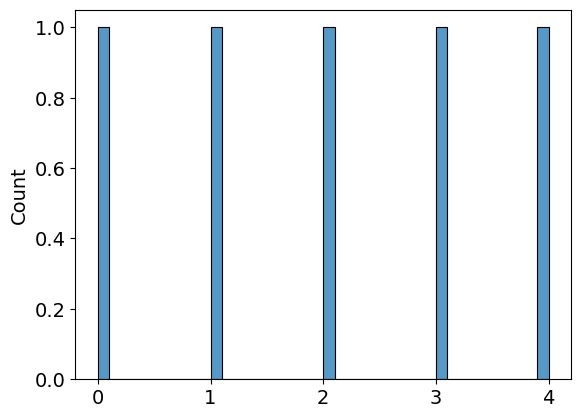

In [8]:
mode_col_idxs = stats.mode(fits_df['evidence'].apply(np.argsort, axis=1).to_numpy()).mode
mode_col_idxs = list(mode_col_idxs[0])
print(mode_col_idxs)
sns.histplot(mode_col_idxs, binwidth=0.1)

In [9]:
if np.unique(mode_col_idxs).shape[0] == len(mode_col_idxs):
    index = list(zip(
        list(zip(*fits_df.columns))[0], 
        fits_df['evidence'].columns[mode_col_idxs].to_list()*2
    ))
    fits_df_srt = fits_df.reindex(index, axis=1)
else:
    model_order = fits_df['evidence'].mean(skipna=True).sort_values().index.to_list()
    index = list(zip(
        list(zip(*fits_df.columns))[0], 
        model_order*2
    ))
    fits_df_srt = fits_df.reindex(index, axis=1)
fits_df_srt.head(n=5)

evidence                                                      \
sbm               sbm--a     sbm-dc-d     sbm-dc-h     sbm-nd-d     sbm-nd-h   
sub ses run                                                                    
1   1   0   -7192.538442 -6739.330287          NaN  -6577.57004 -6534.465287   
    2   0   -7064.143682 -6655.234076 -6636.347749 -6593.140076  -6542.03061   
    3   0   -7054.718139 -6651.722328  -6609.35665 -6546.892943  -6494.19689   
2   1   0   -6843.045927 -6408.384486 -6368.142153 -6337.029448 -6229.741573   
    2   0   -7085.601074 -6739.560972 -6710.052692 -6642.433105  -6592.83599   

            converged                                      
sbm            sbm--a sbm-dc-d sbm-dc-h sbm-nd-d sbm-nd-h  
sub ses run                                                
1   1   0        True    False      NaN    False    False  
    2   0        True     True    False    False    False  
    3   0        True    False    False    False    False  
2   1   0        True     True    False    False    False  
    2   0        True    False    False     True    False

In [10]:
# fits_df_srt['evidence'] = fits_df_srt['evidence'].to_numpy() * fits_df_srt['converged'].to_numpy()
# fits_df_srt = fits_df_srt.replace(to_replace=0.0, value=np.nan)
# fits_df_srt

[Text(0.5, 1.0, 'graph density: 25%'),
 Text(0, 0.5, 'total evidence, log $P(A | M)$'),
 Text(0.5, 0, 'model class, $M$')]

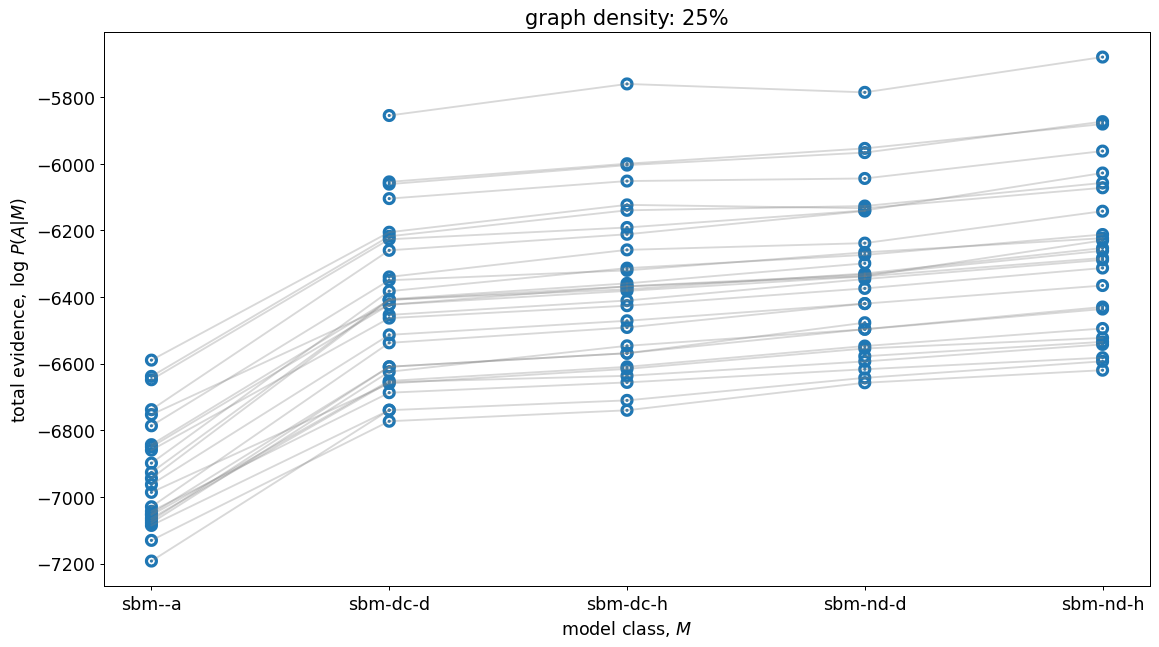

In [11]:
# colors = ['blanchedalmond', 'tab:blue', 'tab:grey']
colors = ['tab:blue', 'tab:blue', 'tab:grey']
cols = fits_df_srt['evidence'].columns.to_list()
fits_df_srt_xy = copy.deepcopy(fits_df_srt)

for idx, (col, vals) in enumerate(fits_df_srt_xy['evidence'].iteritems()):
    fits_df_srt_xy[('evidence', col)] = list(zip([idx]*len(vals), vals.to_numpy()))
fits_df_srt_xy.head(n=5)

fig, axs = plt.subplots(1, 1, figsize=(15, 8), dpi=90)
ax = axs

for col in cols:
    x, y = list(zip(*fits_df_srt_xy[('evidence', col)]))
    
    c = [
        colors[i] 
        for i in 
        np.nan_to_num(fits_df_srt_xy[('converged', col)].to_list(), nan=-1).astype(int)
    ]
    ax.scatter(*list(zip(*fits_df_srt_xy[('evidence', col)])), s=25, color=c, marker='.', linewidths=8)
    
for idx in range(len(cols)-1):
    x1, y1 = list(zip(*fits_df_srt_xy['evidence'][fits_df_srt_xy['evidence'].columns[idx]]))
    x2, y2 = list(zip(*fits_df_srt_xy['evidence'][fits_df_srt_xy['evidence'].columns[idx+1]]))
    ax.plot([x1, x2], [y1, y2], color='grey', alpha=0.3)
    
ax.set_xticks(np.arange(len(cols)), cols)
ax.set(
    title=f'graph density: {args.denst}%',
    ylabel='total evidence, log $P(A | M)$', 
    xlabel='model class, $M$',
)
# ax.grid(True)

In [12]:
fits_df_srt['evidence']

sbm               sbm--a     sbm-dc-d     sbm-dc-h     sbm-nd-d     sbm-nd-h
sub ses run                                                                 
1   1   0   -7192.538442 -6739.330287          NaN  -6577.57004 -6534.465287
    2   0   -7064.143682 -6655.234076 -6636.347749 -6593.140076  -6542.03061
    3   0   -7054.718139 -6651.722328  -6609.35665 -6546.892943  -6494.19689
2   1   0   -6843.045927 -6408.384486 -6368.142153 -6337.029448 -6229.741573
    2   0   -7085.601074 -6739.560972 -6710.052692 -6642.433105  -6592.83599
    3   0            NaN -6453.385319 -6410.219255 -6345.750886 -6288.322852
3   1   0    -7043.14794 -6687.006489  -6656.17662 -6616.642334 -6581.937974
    2   0            NaN -5854.708542 -5759.893214  -5785.20713 -5679.186543
    3   0    -6962.79508 -6513.288556  -6471.06241 -6419.434689          NaN
4   1   0   -7029.466932 -6537.311351 -6491.119083 -6419.568427 -6365.247197
    2   0    -7070.84578 -6609.097772 -6568.574333 -6476.901731          NaN
    3   0    -6926.37918 -6406.501983   -6358.7874 -6298.688056          NaN
5   1   0   -6986.277207 -6659.277401 -6615.527669 -6554.358737  -6522.57619
    2   0   -6752.857228 -6423.011525 -6367.499943 -6332.514788 -6260.956136
    3   0   -6786.375649 -6349.421326 -6319.773484 -6265.698282 -6223.115844
6   1   0   -6737.905325 -6259.546977 -6211.337979 -6141.372006          NaN
    2   0   -6849.691134 -6422.954654 -6381.296395 -6337.940868 -6282.582753
    3   0   -7077.885322 -6624.160355  -6546.30478 -6496.635831 -6435.850207
7   1   0            NaN -6339.401199   -6258.1754 -6237.917188 -6142.040704
    2   0    -7130.45842 -6772.730778 -6739.844581 -6657.210279 -6619.469518
    3   0   -6859.507318 -6463.035808  -6425.82652 -6373.914055 -6312.697738
8   1   0            NaN -6054.023139 -5999.474404 -5953.471753 -5880.395547
    2   0            NaN -6060.789845 -6003.656003 -5966.106776 -5873.092065
    3   0   -6898.462514 -6382.230921 -6313.035704 -6273.272061 -6212.031459
9   1   0   -6648.109523 -6226.358022 -6190.951402 -6139.983521 -6027.333831
    2   0   -6589.207291  -6205.19584 -6123.052255 -6133.110184 -6071.804584
    3   0   -6944.074311  -6408.30117 -6376.550904 -6329.007382  -6252.63944
10  1   0    -7050.40308 -6609.207498 -6568.308219  -6496.33268 -6429.702813
    2   0            NaN -6104.181115  -6051.54816 -6043.751383 -5961.532813
    3   0    -6638.07833 -6217.411608 -6139.398243 -6126.522405 -6057.152296

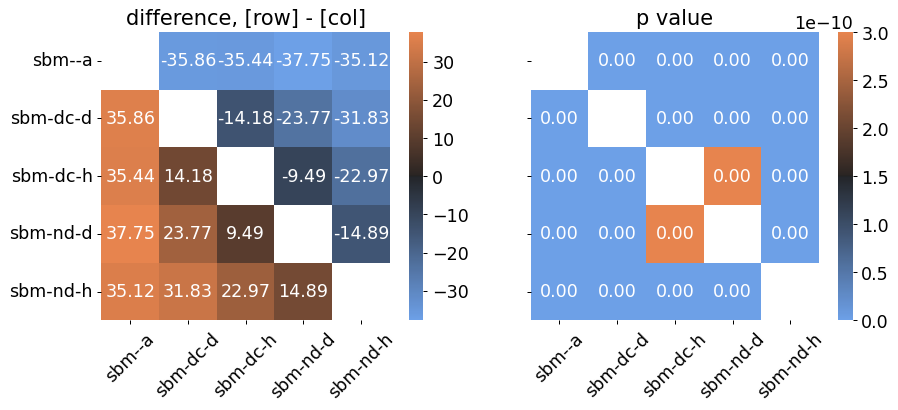

In [13]:
import numpy.ma as ma

sbms = fits_df_srt['evidence'].columns.to_list()
S = np.zeros((len(sbms), len(sbms)))
P = np.zeros((len(sbms), len(sbms)))
for col1, col2 in product(range(len(sbms)), range(len(sbms))):
    a = fits_df_srt['evidence'][sbms[col1]].to_list()
    b = fits_df_srt['evidence'][sbms[col2]].to_list()
    res = stats.ttest_rel(a, b, nan_policy='omit')
    S[col1, col2] = res.statistic
    P[col1, col2] = res.pvalue

mask = np.zeros_like(S, dtype=bool)
mask[np.triu_indices_from(mask)] = True
mS = ma.masked_array(S, mask=mask)
mP = ma.masked_array(P, mask=mask.T)

ncols, nrows = 2, 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=90, sharey=True, sharex=True)
fig.tight_layout()

def plot(M, ax, title='difference'):
    sns.heatmap(
        M, 
        ax=ax, 
        square=True,
        cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),
        annot=True,
        fmt='.2f'
    )

    ax.set_xticks(ticks=np.arange(len(sbms))+0.5, labels=sbms, rotation=45)
    ax.set_yticks(ticks=np.arange(len(sbms))+0.5, labels=sbms, rotation=0)
    ax.set(title=title)

    mult_comp_corr = M.shape[0] * (M.shape[0]-1) / 2
    for i, j in product(range(P.shape[0]), range(P.shape[1])):
        if P[i, j] > 0.005 / mult_comp_corr:
            ax.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='tab:red', lw=3))
            
ax = axs[0]
plot(mS, ax, title='difference, [row] - [col]')

ax = axs[1]
plot(mP, ax, title='p value')